In [1]:
from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim_templates.models import SmallMultinomialLogitStep
from urbansim.utils import misc
import orca
import os; os.chdir('../')
import warnings; warnings.simplefilter('ignore')

import pandas as pd
# import pandana as pdna
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import os
from functools import reduce

import scipy.stats as st
from scipy.stats import skewnorm

from scripts import datasources, models, variables

# import matplotlib
# matplotlib.style.use('ggplot')

%matplotlib inline

pd.options.display.max_columns = 80

Registering model step 'auto_ownership'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [2]:
import glob
import pyproj as proj
from shapely.geometry import MultiPoint
from shapely import geometry

import seaborn as sns
%matplotlib notebook

# %load_ext memory_profiler

## Load Data

In [3]:
trips = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/notebooks-emma/HWtrips_101418.csv')

trips.head()

,Unnamed: 0,HHPER,HHPERTRIP,origin,origin_dwell,origin_ST,origin_ET,trip_ET,TT,Ozone,Dzone,Oxcord,Oycord,Dxcord,Dycord,MODE
0,0,10352742,1.035274e+09,home,13.583333,19.166667,8.75,9.166667,0.416667,424.0,700.0,-122.017274,37.388281,-121.664242,37.151629,drive_alone
1,1,10352742,1.035274e+09,work,7.583333,9.166667,16.75,19.166667,2.416667,700.0,424.0,-121.664242,37.151629,-122.017274,37.388281,drive_alone
2,2,10414944,1.041494e+09,home,14.500000,18.000000,8.50,8.750000,0.250000,1095.0,1152.0,-122.091521,38.010760,-122.118103,37.885783,drive_alone
3,3,10414944,1.041494e+09,work,8.750000,8.750000,17.50,18.000000,0.500000,1152.0,1095.0,-122.118103,37.885783,-122.091521,38.010760,drive_alone
4,4,10417661,1.041766e+09,home,13.250000,18.750000,8.00,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone


In [6]:
# trips = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/notebooks-emma/')
 
emma_data = '/home/emma/ual_model_workspace/fall-2018-models/notebooks-emma/'
!ls emma_data

ls: cannot access 'emma_data': No such file or directory


In [7]:
pd.read_csv(emma_data+'/cleaning_CHTS_data_school.ipynb')


ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 2


In [5]:
trips.HHPER.nunique()

5862

## Prepare TOD and Dwell columns

In [6]:
#select people who make both home-work and work-home trips:
trips = trips.groupby('HHPER').filter(lambda x: len(x) == 2)

In [7]:
#make sure all home-work trip rows are listed first
trips = trips.sort_values(['HHPER','origin']).reset_index()

In [8]:
#move work-home trip info up into home-work trip rows

trips['work_dwell'] = trips.groupby('HHPER', group_keys=False).origin_dwell.shift(-1)
trips['work_ST'] = trips.groupby('HHPER', group_keys=False).origin_ST.shift(-1)
trips['WH_trip_ST'] = trips.groupby('HHPER', group_keys=False).origin_ET.shift(-1)
trips['WH_trip_ET'] = trips.groupby('HHPER', group_keys=False).trip_ET.shift(-1)
trips['WH_TT'] = trips.groupby('HHPER', group_keys=False).TT.shift(-1)
trips['WH_mode'] = trips.groupby('HHPER', group_keys=False).MODE.shift(-1)

In [9]:
trips = trips.groupby('HHPER').first().reset_index()

In [10]:
trips.rename(columns = {'origin_dwell':'home_dwell','origin_ST':'home_ST','origin_ET':'HW_trip_ST',
                           'trip_ET':'HW_trip_ET','TT':'HW_TT','MODE':'HW_mode',
                          'Ozone':'Hzone','Dzone':'Wzone','Oxcord':'Hxcord','Oycord':'Hycord',
                          'Dxcord':'Wxcord','Dycord':'Wycord'},inplace = True)

trips.head()

,HHPER,index,Unnamed: 0,HHPERTRIP,origin,home_dwell,home_ST,HW_trip_ST,HW_trip_ET,HW_TT,Hzone,Wzone,Hxcord,Hycord,Wxcord,Wycord,HW_mode,work_dwell,work_ST,WH_trip_ST,WH_trip_ET,WH_TT,WH_mode
0,10352742,0,0,1.035274e+09,home,13.583333,19.166667,8.750000,9.166667,0.416667,424.0,700.0,-122.017274,37.388281,-121.664242,37.151629,drive_alone,7.583333,9.166667,16.75,19.166667,2.416667,drive_alone
1,10414944,2,2,1.041494e+09,home,14.500000,18.000000,8.500000,8.750000,0.250000,1095.0,1152.0,-122.091521,38.010760,-122.118103,37.885783,drive_alone,8.750000,8.750000,17.50,18.000000,0.500000,drive_alone
2,10417661,4,4,1.041766e+09,home,13.250000,18.750000,8.000000,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone,8.500000,9.000000,17.50,18.750000,1.250000,drive_alone
3,10417662,6,6,1.041766e+09,home,13.000000,19.000000,8.000000,8.500000,0.500000,241.0,282.0,-122.414811,37.610585,-122.328418,37.536798,drive_alone,10.000000,8.500000,18.50,19.000000,0.500000,drive_alone
4,10436132,8,8,1.043613e+09,home,11.866667,19.400000,7.266667,7.866667,0.600000,1004.0,1127.0,-122.252523,37.851942,-122.069993,37.969472,drive_alone,11.133333,7.866667,19.00,19.400000,0.400000,drive_alone


In [11]:
mode_dict = dict(zip(['drive_alone', 'shared',
                      'WTranW','DrTranW','WTranDr',
                      'bike', 'walk'],range(7)))
trips['modeHW'] = trips['HW_mode'].replace(mode_dict)

In [12]:
trips.head()

,HHPER,index,Unnamed: 0,HHPERTRIP,origin,home_dwell,home_ST,HW_trip_ST,HW_trip_ET,HW_TT,Hzone,Wzone,Hxcord,Hycord,Wxcord,Wycord,HW_mode,work_dwell,work_ST,WH_trip_ST,WH_trip_ET,WH_TT,WH_mode,modeHW
0,10352742,0,0,1.035274e+09,home,13.583333,19.166667,8.750000,9.166667,0.416667,424.0,700.0,-122.017274,37.388281,-121.664242,37.151629,drive_alone,7.583333,9.166667,16.75,19.166667,2.416667,drive_alone,0
1,10414944,2,2,1.041494e+09,home,14.500000,18.000000,8.500000,8.750000,0.250000,1095.0,1152.0,-122.091521,38.010760,-122.118103,37.885783,drive_alone,8.750000,8.750000,17.50,18.000000,0.500000,drive_alone,0
2,10417661,4,4,1.041766e+09,home,13.250000,18.750000,8.000000,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone,8.500000,9.000000,17.50,18.750000,1.250000,drive_alone,0
3,10417662,6,6,1.041766e+09,home,13.000000,19.000000,8.000000,8.500000,0.500000,241.0,282.0,-122.414811,37.610585,-122.328418,37.536798,drive_alone,10.000000,8.500000,18.50,19.000000,0.500000,drive_alone,0
4,10436132,8,8,1.043613e+09,home,11.866667,19.400000,7.266667,7.866667,0.600000,1004.0,1127.0,-122.252523,37.851942,-122.069993,37.969472,drive_alone,11.133333,7.866667,19.00,19.400000,0.400000,drive_alone,0


In [13]:
trips['TOD'] = (
    ((trips.HW_trip_ET.between(3,6,inclusive = False)) | (trips.HW_trip_ET==3))*1 +
    ((trips.HW_trip_ET.between(6,9,inclusive = False)) | (trips.HW_trip_ET==6))*2 +
    ((trips.HW_trip_ET.between(9,15.5,inclusive = False)) | (trips.HW_trip_ET==9))*3 +
    ((trips.HW_trip_ET.between(15.5,18.5,inclusive = False)) | (trips.HW_trip_ET==15.5))*4 +
    ((trips.HW_trip_ET>=18.5))*5 +
    ((trips.HW_trip_ET.between(0,3,inclusive = False)) | (trips.HW_trip_ET==0))*5
)

trips['TOD'] = trips['TOD'] - 1

In [14]:
trips['TOD'] = pd.to_numeric(trips['TOD'])

In [15]:
trips['dwell_work'] = (
    ((trips.work_dwell.between(0,4.5,inclusive = False)) | (trips.work_dwell==0))*1 +
    ((trips.work_dwell.between(4.5,7.75,inclusive = False)) | (trips.work_dwell==4.5))*2 +
    ((trips.work_dwell.between(7.75,9.0,inclusive = False)) | (trips.work_dwell==7.75))*3 +
    ((trips.work_dwell.between(9.0,10.5,inclusive = False)) | (trips.work_dwell==9.0))*4 +
    ((trips.work_dwell>=10.5))*5)

## Add the demographic variables

In [16]:
person = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_PER.csv')[
    ['SAMPN','PERNO','GEND','AGE','HISP','RACE1','RACE2','RACE3','RACE4',
                 'HOURS','EDUCA','INDUS']]

person.head()

,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,HOURS,EDUCA,INDUS
0,1031985,1,1,74,2,1.0,NaN,NaN,NaN,NaN,6,NaN
1,1031985,2,2,73,2,1.0,NaN,NaN,NaN,NaN,6,NaN
2,1032036,1,1,46,2,1.0,NaN,NaN,NaN,40.0,6,54.0
3,1032036,2,2,47,2,1.0,97.0,NaN,NaN,NaN,6,NaN
4,1032036,3,1,15,2,1.0,97.0,NaN,NaN,NaN,1,NaN


In [17]:
person['HHPER'] = person['SAMPN'].map(str) + person['PERNO'].map(str)

In [18]:
hh_df = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_HH.csv')[
  ['SAMPN','HHVEH',
   'OWN','INCOM','HHSIZ']]

hh_df.head()

,SAMPN,HHVEH,OWN,INCOM,HHSIZ
0,1031985,2,1,3,2
1,1032036,1,1,7,5
2,1032053,2,2,2,6
3,1032425,2,1,7,2
4,1032558,0,2,1,1


In [19]:
demo = person.merge(hh_df,on = 'SAMPN',how = 'left')

demo.head()

,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,HOURS,EDUCA,INDUS,HHPER,HHVEH,OWN,INCOM,HHSIZ
0,1031985,1,1,74,2,1.0,NaN,NaN,NaN,NaN,6,NaN,10319851,2,1,3,2
1,1031985,2,2,73,2,1.0,NaN,NaN,NaN,NaN,6,NaN,10319852,2,1,3,2
2,1032036,1,1,46,2,1.0,NaN,NaN,NaN,40.0,6,54.0,10320361,1,1,7,5
3,1032036,2,2,47,2,1.0,97.0,NaN,NaN,NaN,6,NaN,10320362,1,1,7,5
4,1032036,3,1,15,2,1.0,97.0,NaN,NaN,NaN,1,NaN,10320363,1,1,7,5


## Get rid of null values

In [20]:
na_dict = {
    'GEND':[9],
    'AGE':[998,999],
    'HOURS':[998,999],
    'EDUCA':[8,9],
    'HHVEH':[98,99],
    'OWN':[7,8,9],
    'INCOM':[98,99],
    'HHSIZ':[98,99],
    'INDUS':[98,99],
}

for col in na_dict:
    for vals in na_dict[col]:
        demo[col] = demo[col].replace(vals,np.nan)

In [21]:
demo = demo.dropna(subset = ['GEND', 'AGE', 'HOURS', 'EDUCA','HHVEH','OWN','INCOM','HHSIZ','INDUS'])

In [22]:
trips['HHPER'] = trips['HHPER'].map(str)

trips1 = pd.merge(trips, demo, on='HHPER')

print (len(trips.index))
print (len(trips1.index))

5733
4890


## Prepare data for use in MNL estimation (make dummy columns)

In [23]:
trips1['minority'] = np.where((trips1['HISP'].isin([1.0]) |
                                trips1['RACE1'].isin([2.0]) | trips1['RACE2'].isin([2.0]) | trips1['RACE3'].isin([2.0]) | trips1['RACE4'].isin([2.0]) |
                              trips1['RACE1'].isin([3.0]) | trips1['RACE2'].isin([3.0]) | trips1['RACE3'].isin([3.0]) | trips1['RACE4'].isin([3.0]) |
                              trips1['RACE1'].isin([4.0]) | trips1['RACE2'].isin([4.0]) | trips1['RACE3'].isin([4.0]) | trips1['RACE4'].isin([4.0]) |
                              trips1['RACE1'].isin([5.0]) | trips1['RACE2'].isin([5.0]) | trips1['RACE3'].isin([5.0]) | trips1['RACE4'].isin([5.0]) |
                              trips1['RACE1'].isin([97.0]) | trips1['RACE2'].isin([97.0]) | trips1['RACE3'].isin([97.0]) | trips1['RACE4'].isin([97.0])),1,0)

trips1['HISP'] = np.where(trips1['HISP'].isin([1.0]),1,0)
trips1['black'] = np.where((trips1['RACE1'].isin([2.0]) | trips1['RACE2'].isin([2.0]) | trips1['RACE3'].isin([2.0]) | trips1['RACE4'].isin([2.0])),1,0)
trips1['native'] = np.where((trips1['RACE1'].isin([3.0]) | trips1['RACE2'].isin([3.0]) | trips1['RACE3'].isin([3.0]) | trips1['RACE4'].isin([3.0])),1,0)
trips1['asian'] = np.where((trips1['RACE1'].isin([4.0]) | trips1['RACE2'].isin([4.0]) | trips1['RACE3'].isin([4.0]) | trips1['RACE4'].isin([4.0])),1,0)
trips1['PI'] = np.where((trips1['RACE1'].isin([5.0]) | trips1['RACE2'].isin([5.0]) | trips1['RACE3'].isin([5.0]) | trips1['RACE4'].isin([5.0])),1,0)


In [24]:
trips1['hh_inc_less10k'] = np.where(trips1['INCOM'].isin([1.0]),1,0)
trips1['hh_inc_10kless25k'] = np.where(trips1['INCOM'].isin([2.0]),1,0)
trips1['hh_inc_25kless35k'] = np.where(trips1['INCOM'].isin([3.0]),1,0)
trips1['hh_inc_35kless50k'] = np.where(trips1['INCOM'].isin([4.0]),1,0)
trips1['hh_inc_50kless75k'] = np.where(trips1['INCOM'].isin([5.0]),1,0)
# trips1['hh_inc_75kless100k'] = np.where(trips1['INCOM'].isin([6.0]),1,0)
trips1['hh_inc_100kless150k'] = np.where(trips1['INCOM'].isin([7.0]),1,0)
trips1['hh_inc_150kless200k'] = np.where(trips1['INCOM'].isin([8.0]),1,0)
trips1['hh_inc_200kless250k'] = np.where(trips1['INCOM'].isin([9.0]),1,0)
# trips1['250kplus'] = np.where(trips1['INCOM'].isin([10.0]),1,0)

trips1['hh_inc_less50k'] = np.where(trips1['INCOM'].isin([1.0,2.0,3.0,4.0]),1,0)
# trips1['less75k'] = np.where(trips1['INCOM'].isin([1.0,2.0,3.0,4.0,5.0]),1,0)
# trips1['150kless250k'] = np.where(trips1['INCOM'].isin([8.0,9.0]),1,0)
# trips1['150kplus'] = np.where(trips1['INCOM'].isin([8.0,9.0,10.0]),1,0)

trips1['hh_inc_less75k'] = np.where(trips1['INCOM'].isin([1.0,2.0,3.0,4.0,5.0]),1,0)
trips1['hh_inc_75kless100k'] = np.where(trips1['INCOM'].isin([6.0]),1,0)
trips1['hh_inc_150kplus'] = np.where(trips1['INCOM'].isin([8.0,9.0,10.0]),1,0)
trips1['hh_inc_150kless250k'] = np.where(trips1['INCOM'].isin([8.0,9.0]),1,0)
trips1['hh_inc_250kplus'] = np.where(trips1['INCOM'].isin([10.0]),1,0)

In [25]:
trips1['lessGED'] = np.where(trips1['EDUCA'].isin([1.0]),1,0)
trips1['GED'] = np.where(trips1['EDUCA'].isin([2.0]),1,0)
trips1['somebach'] = np.where(trips1['EDUCA'].isin([3.0]),1,0)
trips1['Assoc'] = np.where(trips1['EDUCA'].isin([4.0]),1,0)
trips1['Bach'] = np.where(trips1['EDUCA'].isin([5.0]),1,0)

trips1['lessGED_GED'] = np.where(trips1['EDUCA'].isin([1.0,2.0]),1,0)

trips1['lessbach'] = (trips1['EDUCA'] < 5).astype(int)

In [26]:
trips1['age_16less25'] = np.where(((trips1.AGE.between(16,25,inclusive = False)) | (trips1.AGE==16)),1,0)
trips1['age_25less40'] = np.where(((trips1.AGE.between(25,40,inclusive = False)) | (trips1.AGE==25)),1,0)
trips1['age_40less50'] = np.where(((trips1.AGE.between(40,50,inclusive = False)) | (trips1.AGE==40)),1,0)
trips1['age_50less60'] = np.where(((trips1.AGE.between(50,60,inclusive = False)) | (trips1.AGE==50)),1,0)

In [27]:
trips1.rename(columns = {'HOURS':'hours'},inplace = True)

trips1['female'] = trips1['GEND'] - 1

trips1['tenure_2'] = trips1['OWN'] - 1

trips1['noveh'] = np.where(trips1.HHVEH.isin([0.0]),1,0)
trips1['1veh'] = np.where(trips1.HHVEH.isin([1.0]),1,0)
trips1['2veh'] = np.where(trips1.HHVEH.isin([2.0]),1,0)
trips1['3plusveh'] = np.where(trips1.HHVEH.between(3,8,inclusive = True),1,0)

trips1['hh_size_1per'] = np.where(trips1.HHSIZ.isin([1.0]),1,0)
trips1['hh_size_2per'] = np.where(trips1.HHSIZ.isin([2.0]),1,0)
trips1['hh_size_3per'] = np.where(trips1.HHSIZ.isin([3.0]),1,0)
trips1['hh_size_4plusper'] = np.where(trips1.HHSIZ.between(4,8,inclusive = True),1,0)

In [28]:
trips1['sector_constr'] = np.where(trips1['INDUS'].isin([23]),1,0)
trips1['sector_mfg'] = np.where(trips1['INDUS'].isin([31]),1,0)
trips1['sector_retail'] = np.where(trips1['INDUS'].isin([44,45]),1,0)
trips1['sector_transport'] = np.where(trips1['INDUS'].isin([48]),1,0)
trips1['info'] = np.where(trips1['INDUS'].isin([51]),1,0)
trips1['finance'] = np.where(trips1['INDUS'].isin([52]),1,0)
trips1['scitech'] = np.where(trips1['INDUS'].isin([54]),1,0)
trips1['sector_edu_serv'] = np.where(trips1['INDUS'].isin([61]),1,0)
trips1['sector_healthcare'] = np.where(trips1['INDUS'].isin([62]),1,0)
trips1['sector_oth_serv'] = np.where(trips1['INDUS'].isin([81]),1,0)
trips1['sector_gov'] = np.where(trips1['INDUS'].isin([92]),1,0)

In [29]:
trips1['TOD_3to6'] = np.where(trips1['TOD'].isin([0]),1,0)
trips1['TOD_6to9'] = np.where(trips1['TOD'].isin([1]),1,0)
trips1['TOD_9to1530'] = np.where(trips1['TOD'].isin([2]),1,0)
trips1['TOD_1530to1830'] = np.where(trips1['TOD'].isin([3]),1,0)
trips1['TOD_1830up'] = np.where(trips1['TOD'].isin([4]),1,0)

trips1['TOD_9up'] = np.where(trips1['TOD'].isin([2,3,4]),1,0)
trips1['TOD_1530up'] = np.where(trips1['TOD'].isin([3,4]),1,0)

In [30]:
trips1['sector_constr'] = np.where(trips1['INDUS'].isin([23]),1,0)
trips1['sector_mfg'] = np.where(trips1['INDUS'].isin([31]),1,0)
trips1['sector_retail'] = np.where(trips1['INDUS'].isin([44,45]),1,0)
trips1['sector_transport'] = np.where(trips1['INDUS'].isin([48]),1,0)
trips1['info'] = np.where(trips1['INDUS'].isin([51]),1,0)
trips1['finance'] = np.where(trips1['INDUS'].isin([52]),1,0)
trips1['scitech'] = np.where(trips1['INDUS'].isin([54]),1,0)
trips1['sector_edu_serv'] = np.where(trips1['INDUS'].isin([61]),1,0)
trips1['sector_healthcare'] = np.where(trips1['INDUS'].isin([62]),1,0)
trips1['sector_oth_serv'] = np.where(trips1['INDUS'].isin([81]),1,0)
trips1['sector_gov'] = np.where(trips1['INDUS'].isin([92]),1,0)

In [31]:
trips1.head()

,HHPER,index,Unnamed: 0,HHPERTRIP,origin,home_dwell,home_ST,HW_trip_ST,HW_trip_ET,HW_TT,Hzone,Wzone,Hxcord,Hycord,Wxcord,Wycord,HW_mode,work_dwell,work_ST,WH_trip_ST,WH_trip_ET,WH_TT,WH_mode,modeHW,TOD,dwell_work,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,hours,EDUCA,INDUS,HHVEH,OWN,...,hh_inc_250kplus,lessGED,GED,somebach,Assoc,Bach,lessGED_GED,lessbach,age_16less25,age_25less40,age_40less50,age_50less60,female,tenure_2,noveh,1veh,2veh,3plusveh,hh_size_1per,hh_size_2per,hh_size_3per,hh_size_4plusper,sector_constr,sector_mfg,sector_retail,sector_transport,info,finance,scitech,sector_edu_serv,sector_healthcare,sector_oth_serv,sector_gov,TOD_3to6,TOD_6to9,TOD_9to1530,TOD_1530to1830,TOD_1830up,TOD_9up,TOD_1530up
0,10414944,2,2,1.041494e+09,home,14.500000,18.000000,8.500000,8.750000,0.250000,1095.0,1152.0,-122.091521,38.010760,-122.118103,37.885783,drive_alone,8.750000,8.750000,17.50,18.000000,0.500000,drive_alone,0,1,3,1041494,4,2.0,36.0,0,3.0,NaN,NaN,NaN,8.0,2.0,71.0,3,1.0,...,0,0,1,0,0,0,1,1,0,1,0,0,1.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,10417661,4,4,1.041766e+09,home,13.250000,18.750000,8.000000,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone,8.500000,9.000000,17.50,18.750000,1.250000,drive_alone,0,2,3,1041766,1,2.0,43.0,0,4.0,NaN,NaN,NaN,40.0,6.0,62.0,2,1.0,...,1,0,0,0,0,0,0,0,0,0,1,0,1.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
2,10417662,6,6,1.041766e+09,home,13.000000,19.000000,8.000000,8.500000,0.500000,241.0,282.0,-122.414811,37.610585,-122.328418,37.536798,drive_alone,10.000000,8.500000,18.50,19.000000,0.500000,drive_alone,0,1,4,1041766,2,1.0,44.0,0,4.0,NaN,NaN,NaN,60.0,3.0,51.0,2,1.0,...,1,0,0,1,0,0,0,1,0,0,1,0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,10436132,8,8,1.043613e+09,home,11.866667,19.400000,7.266667,7.866667,0.600000,1004.0,1127.0,-122.252523,37.851942,-122.069993,37.969472,drive_alone,11.133333,7.866667,19.00,19.400000,0.400000,drive_alone,0,1,5,1043613,2,1.0,54.0,0,1.0,NaN,NaN,NaN,12.0,6.0,61.0,2,1.0,...,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,10456071,10,10,1.045607e+09,home,13.416667,16.916667,6.333333,7.000000,0.666667,908.0,116.0,-122.189451,37.790664,-122.410761,37.759579,shared,8.250000,7.000000,15.25,16.916667,1.666667,WTranW,1,1,3,1045607,1,1.0,57.0,0,1.0,NaN,NaN,NaN,40.0,3.0,51.0,1,1.0,...,0,0,0,1,0,0,0,1,0,0,0,1,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


## BEAM skims

In [32]:
warnings.simplefilter('ignore')
accessibilities_mode = 'compute'
year = 2010
scenario = None
data_mode = 'csv'
output_format = 'csv'
local_data_dir = '/home/data/spring_2019/base/'

csv_fnames = {
    'parcels': 'parcel_attr.csv',
    'buildings': 'buildings_v2.csv',
    'jobs': 'jobs_v2.csv',
    'establishments': 'establishments_v2.csv',
    'households': 'households_v2.csv',
    'persons': 'persons_v3.csv',
    'rentals': 'MTC_craigslist_listings_7-10-18.csv',
    'units': 'units_v2.csv',
    'skims': 'skims_110118.csv',
    'beam_drive_skims': 'sfbay-smart-base__2019-03-28_14-22-12/' +
            'ITERS/it.30/30.skimsExcerpt.csv',
    'beam_skims': 'sfbay-smart-base__2019-03-28_14-22-12/' +
            'ITERS/it.30/30.skims.csv',
    'drive_nodes': 'bay_area_tertiary_strongly_nodes.csv',
    'drive_edges': 'bay_area_tertiary_strongly_edges.csv',
    'drive_access_vars': 'drive_net_vars.csv',
    'walk_nodes': 'bayarea_walk_nodes.csv',
    'walk_edges': 'bayarea_walk_edges.csv',
    'walk_access_vars': 'walk_net_vars.csv',
    'zones': 'zones.csv',
    'zone_access_vars': 'zones_w_access_vars.csv'
}

In [33]:
orca.add_injectable('csv_fnames', csv_fnames)
orca.add_injectable('data_mode', data_mode)
orca.add_injectable('store', None)
orca.add_injectable('s3_input_data_url', None)
orca.add_injectable('local_data_dir', local_data_dir)

In [34]:
def send_output_to_s3(
        output_tables, io_bucket, beam_bucket, year, scenario=None,
        output_format='parquet'):

    # save tables to s3
    if output_format == 'csv':
        s3 = s3fs.S3FileSystem(anon=False)

    for table_name in output_tables:
        print(table_name)
        table = orca.get_table(table_name)
        df = table.to_frame(table.local_columns)
        if scenario:
            table_name = scenario + '/' + table_name
        s3_url = 's3://{0}/{1}/{2}.{3}'.format(
            io_bucket, year, table_name, output_format)
        if output_format == 'parquet':
            df.to_parquet(s3_url, engine='pyarrow')
        elif output_format == 'csv':
            with s3.open(s3_url, 'w') as f:
                df.to_csv(f)

    # save plans to s3
    table_name = 'activity_plans'
    print(table_name)
    plans = orca.get_table('plans').to_frame()
    if scenario:
        table_name = scenario + '/' + table_name
    s3_url = 's3://{0}/{1}/{2}.{3}'.format(
        beam_bucket, year, table_name, output_format)
    if output_format == 'parquet':
        plans.to_parquet(s3_url)
    elif output_format == 'csv':
        with s3.open(s3_url, 'w') as f:
            plans.to_csv(f)

In [35]:
orca.run(['initialize_network_small', 'initialize_network_walk'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [34]:
# orca.run(['initialize_network_small', 'network_aggregations_small'])

In [47]:
# orca.run(['initialize_network_walk', 'network_aggregations_walk'])

Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Running step 'network_aggregations_walk'
Computing accessibility variables
Computing units_500_walk
Computing sqft_unit_500_walk
Computing singles_500_walk
Removed 52084 rows because they contain missing values
Computing elderly_hh_500_walk
Removed 34553 rows because they contain missing values
Computing children_500_walk
Removed 189769 rows because they contain missing values
Computing units_sf_500_walk
Computing units_mf_500_walk
Computing pop_500_walk
Removed 189769 rows because they contain missing values
Computing hh_500_walk
Removed 189769 rows because they contain missing values
Computing poor_500_walk
Removed 53114 rows because they contain missing values
Computing rich_500_walk
Removed 38964 rows because they contain missing values
Computing renters_500_walk
Removed 102597 rows because they contain missing values
Computing avg_income_500_walk
Removed 189769 rows because they contain m

In [37]:
orca.run(['impute_missing_skims'])

In [35]:
orca.run(['skims_aggregations_drive'])

Running step 'skims_aggregations_drive'
Time to execute step 'skims_aggregations_drive': 18.67 s
Total time to execute iteration 1 with iteration value None: 18.67 s


In [36]:
orca.run(['skims_aggregations_other'])

Running step 'skims_aggregations_other'
Time to execute step 'skims_aggregations_other': 0.01 s
Total time to execute iteration 1 with iteration value None: 0.01 s


In [127]:
zones = orca.get_table('zones').to_frame()

In [38]:
len(zones)

1454

In [39]:
zones.head()

,gid,area,acres,total_jobs,sum_residential_units,sum_persons,sum_income,avg_income,total_jobs_gen_tt_CAR_AM_15,total_jobs_gen_tt_CAR_AM_30,total_jobs_gen_tt_CAR_AM_45,sum_persons_gen_tt_CAR_AM_15,sum_persons_gen_tt_CAR_AM_30,sum_persons_gen_tt_CAR_AM_45,sum_income_gen_tt_CAR_AM_15,sum_income_gen_tt_CAR_AM_30,sum_income_gen_tt_CAR_AM_45,sum_residential_units_gen_tt_CAR_AM_15,sum_residential_units_gen_tt_CAR_AM_30,sum_residential_units_gen_tt_CAR_AM_45,avg_income_gen_tt_CAR_AM_15,avg_income_gen_tt_CAR_AM_30,avg_income_gen_tt_CAR_AM_45,total_jobs_gen_tt_WALK_TRANSIT_AM_15,total_jobs_gen_tt_WALK_TRANSIT_AM_30,total_jobs_gen_tt_WALK_TRANSIT_AM_45,sum_persons_gen_tt_WALK_TRANSIT_AM_15,sum_persons_gen_tt_WALK_TRANSIT_AM_30,sum_persons_gen_tt_WALK_TRANSIT_AM_45,sum_income_gen_tt_WALK_TRANSIT_AM_15,sum_income_gen_tt_WALK_TRANSIT_AM_30,sum_income_gen_tt_WALK_TRANSIT_AM_45,sum_residential_units_gen_tt_WALK_TRANSIT_AM_15,sum_residential_units_gen_tt_WALK_TRANSIT_AM_30,sum_residential_units_gen_tt_WALK_TRANSIT_AM_45,avg_income_gen_tt_WALK_TRANSIT_AM_15,avg_income_gen_tt_WALK_TRANSIT_AM_30,avg_income_gen_tt_WALK_TRANSIT_AM_45,total_jobs_gen_tt_DRIVE_TRANSIT_AM_15,total_jobs_gen_tt_DRIVE_TRANSIT_AM_30,...,sum_persons_gen_tt_RIDE_HAIL_AM_45,sum_income_gen_tt_RIDE_HAIL_AM_15,sum_income_gen_tt_RIDE_HAIL_AM_30,sum_income_gen_tt_RIDE_HAIL_AM_45,sum_residential_units_gen_tt_RIDE_HAIL_AM_15,sum_residential_units_gen_tt_RIDE_HAIL_AM_30,sum_residential_units_gen_tt_RIDE_HAIL_AM_45,avg_income_gen_tt_RIDE_HAIL_AM_15,avg_income_gen_tt_RIDE_HAIL_AM_30,avg_income_gen_tt_RIDE_HAIL_AM_45,total_jobs_gen_tt_WALK_AM_15,total_jobs_gen_tt_WALK_AM_30,total_jobs_gen_tt_WALK_AM_45,sum_persons_gen_tt_WALK_AM_15,sum_persons_gen_tt_WALK_AM_30,sum_persons_gen_tt_WALK_AM_45,sum_income_gen_tt_WALK_AM_15,sum_income_gen_tt_WALK_AM_30,sum_income_gen_tt_WALK_AM_45,sum_residential_units_gen_tt_WALK_AM_15,sum_residential_units_gen_tt_WALK_AM_30,sum_residential_units_gen_tt_WALK_AM_45,avg_income_gen_tt_WALK_AM_15,avg_income_gen_tt_WALK_AM_30,avg_income_gen_tt_WALK_AM_45,total_jobs_gen_tt_BIKE_AM_15,total_jobs_gen_tt_BIKE_AM_30,total_jobs_gen_tt_BIKE_AM_45,sum_persons_gen_tt_BIKE_AM_15,sum_persons_gen_tt_BIKE_AM_30,sum_persons_gen_tt_BIKE_AM_45,sum_income_gen_tt_BIKE_AM_15,sum_income_gen_tt_BIKE_AM_30,sum_income_gen_tt_BIKE_AM_45,sum_residential_units_gen_tt_BIKE_AM_15,sum_residential_units_gen_tt_BIKE_AM_30,sum_residential_units_gen_tt_BIKE_AM_45,avg_income_gen_tt_BIKE_AM_15,avg_income_gen_tt_BIKE_AM_30,avg_income_gen_tt_BIKE_AM_45
zone_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1442,525,5272042.0,121.028999,2194.0,2567.0,5839.0,477004000.0,207557.460533,36883.0,76135.0,215824.0,80831.0,167106.0,432372.0,5.563193e+09,1.074893e+10,2.403103e+10,38664.0,79558.0,207084.0,358192.924300,354694.210979,338022.050161,11594.0,31912.0,62852.0,34741.0,78704.0,134983.0,2.665514e+09,5.639627e+09,8.900034e+09,16368.0,37319.0,64675.0,384325.026425,364542.810847,357877.186970,28499.0,63305.0,...,96415.0,1.945550e+09,4.650759e+09,6.928568e+09,11508.0,30758.0,47434.0,392585.889501,369848.783932,363859.226719,3287.0,5481.0,7763.0,9848.0,15687.0,19617.0,737147496.0,1.214151e+09,1.478297e+09,4648.0,7215.0,9357.0,354446.957271,384780.939169,374625.804458,9721.0,26830.0,37974.0,24549.0,65525.0,87965.0,1.945550e+09,4.638191e+09,6.479069e+09,11508.0,31355.0,43296.0,392585.889501,368595.904466,366590.247897
1434,508,7820341.5,179.529999,771.0,2425.0,5237.0,313941043.0,141307.478037,16326.0,56297.0,97976.0,43020.0,147581.0,244857.0,2.607083e+09,8.992012e+09,1.369518e+10,20972.0,70109.0,112078.0,290079.380858,288045.450091,275858.163468,4967.0,22999.0,61297.0,27498.0,65709.0,123699.0,1.722969e+09,3.712628e+09,7.311887e+09,12751.0,29488.0,57822.0,288614.635008,288233.624462,281856.004221,14050.0,53653.0,...,92538.0,1.249575e+09,2.531483e+09,5.414574e+09,9877.0,18708.0,43116.0,280727.720924,297629.399234,289073.957947,1110.0,1881.0,1881.0,8370.0,13607.0,13607.0,516619

In [128]:
zones15 = zones[['total_jobs_gen_tt_CAR_AM_15','total_jobs_gen_tt_WALK_TRANSIT_AM_15','total_jobs_gen_tt_DRIVE_TRANSIT_AM_15','total_jobs_gen_tt_BIKE_AM_15','total_jobs_gen_tt_WALK_AM_15',
               'sum_residential_units_gen_tt_CAR_AM_15','sum_residential_units_gen_tt_WALK_TRANSIT_AM_15','sum_residential_units_gen_tt_DRIVE_TRANSIT_AM_15','sum_residential_units_gen_tt_BIKE_AM_15','sum_residential_units_gen_tt_WALK_AM_15',
               'sum_persons_gen_tt_CAR_AM_15','sum_persons_gen_tt_WALK_TRANSIT_AM_15','sum_persons_gen_tt_DRIVE_TRANSIT_AM_15','sum_persons_gen_tt_BIKE_AM_15','sum_persons_gen_tt_WALK_AM_15',
               'avg_income_gen_tt_CAR_AM_15','avg_income_gen_tt_WALK_TRANSIT_AM_15','avg_income_gen_tt_DRIVE_TRANSIT_AM_15','avg_income_gen_tt_BIKE_AM_15','avg_income_gen_tt_WALK_AM_15',
               ]]

In [ ]:
zones30 = zones[['total_jobs_gen_tt_CAR_AM_30','total_jobs_gen_tt_WALK_TRANSIT_AM_30','total_jobs_gen_tt_DRIVE_TRANSIT_AM_30','total_jobs_gen_tt_BIKE_AM_30','total_jobs_gen_tt_WALK_AM_30',
               'sum_residential_units_gen_tt_CAR_AM_30','sum_residential_units_gen_tt_WALK_TRANSIT_AM_30','sum_residential_units_gen_tt_DRIVE_TRANSIT_AM_30','sum_residential_units_gen_tt_BIKE_AM_30','sum_residential_units_gen_tt_WALK_AM_30',
               'sum_persons_gen_tt_CAR_AM_30','sum_persons_gen_tt_WALK_TRANSIT_AM_30','sum_persons_gen_tt_DRIVE_TRANSIT_AM_30','sum_persons_gen_tt_BIKE_AM_30','sum_persons_gen_tt_WALK_AM_30',
               'avg_income_gen_tt_CAR_AM_30','avg_income_gen_tt_WALK_TRANSIT_AM_30','avg_income_gen_tt_DRIVE_TRANSIT_AM_30','avg_income_gen_tt_BIKE_AM_30','avg_income_gen_tt_WALK_AM_30',
               ]]

In [129]:
zones45 = zones[['total_jobs_gen_tt_CAR_AM_45','total_jobs_gen_tt_WALK_TRANSIT_AM_45','total_jobs_gen_tt_DRIVE_TRANSIT_AM_45','total_jobs_gen_tt_BIKE_AM_45','total_jobs_gen_tt_WALK_AM_45',
               'sum_residential_units_gen_tt_CAR_AM_45','sum_residential_units_gen_tt_WALK_TRANSIT_AM_45','sum_residential_units_gen_tt_DRIVE_TRANSIT_AM_45','sum_residential_units_gen_tt_BIKE_AM_45','sum_residential_units_gen_tt_WALK_AM_45',
               'sum_persons_gen_tt_CAR_AM_45','sum_persons_gen_tt_WALK_TRANSIT_AM_45','sum_persons_gen_tt_DRIVE_TRANSIT_AM_45','sum_persons_gen_tt_BIKE_AM_45','sum_persons_gen_tt_WALK_AM_45',
               'avg_income_gen_tt_CAR_AM_45','avg_income_gen_tt_WALK_TRANSIT_AM_45','avg_income_gen_tt_DRIVE_TRANSIT_AM_45','avg_income_gen_tt_BIKE_AM_45','avg_income_gen_tt_WALK_AM_45',
               ]]

In [41]:
skims = orca.get_table('beam_skims').to_frame()

In [42]:
drive_skims = orca.get_table('beam_drive_skims').to_frame()

In [43]:
skims.head()

dist  gen_cost_BIKE_AM  gen_cost_CAR_AM  \
from_zone_id to_zone_id                                                 
1            1            193.1208          0.235573         0.133005   
             2            386.2416          0.471146         0.266009   
             3            708.1096          0.863768         0.487684   
             4            659.8294          0.804875         0.454433   
             5           1094.3512          1.334915         0.753693   

                         gen_cost_DRIVE_TRANSIT_AM  gen_cost_RIDE_HAIL_AM  \
from_zone_id to_zone_id                                                     
1            1                            0.176529               0.951468   
             2                            0.353058               1.902937   
             3                            0.647273               3.488718   
             4                            0.603141               3.250851   
             5                            1.000331               5.391655   

                         gen_cost_RIDE_HAIL_POOLED_AM  \
from_zone_id to_zone_id                                 
1            1                               0.374730   
             2                               0.749460   
             3                               1.374010   
             4                               1.280327   
             5                               2.123469   

                         gen_cost_RIDE_HAIL_TRANSIT_AM  gen_cost_WALK_AM  \
from_zone_id to_zone_id                                                    
1            1                                0.316028         67.521260   
             2                                0.632057        135.042520   
             3                                1.158771        247.577954   
             4                                1.079764        230.697639   
             5                                1.790828        382.620475   

                         gen_cost_WALK_TRANSIT_AM  gen_tt_BIKE_AM  \
from_zone_id to_zone_id                                             
1            1                           0.211499        0.805050   
             2                           0.422999        1.610099   
             3                           0.775497        2.951848   
             4                           0.722623        2.750586   
             5                           1.198496        4.561947   

                         gen_tt_CAR_AM  gen_tt_DRIVE_TRANSIT_AM  \
from_zone_id to_zone_id                                           
1            1                0.211613                 0.353905   
             2                0.423226                 0.707809   
             3                0.775915                 1.297650   
             4                0.723012                 1.209174   
             5                1.199141                 2.005459   

                         gen_tt_RIDE_HAIL_AM  gen_tt_RIDE_HAIL_POOLED_AM  \
from_zone_id to_zone_id                                                    
1            1                      0.700741                    0.329673   
             2                      1.401482                    0.659346   
             3                      2.569383                    1.208801   
             4                      2.394198                    1.126383   
             5                      3.970865                    1.868147   

                         gen_tt_RIDE_HAIL_TRANSIT_AM  gen_tt_WALK_AM  \
from_zone_id to_zone_id                                                
1            1                              0.318411        3.517144   
             2                              0.636822        7.034287   
             3                              1.167507       12.896193   
             4                              1.087904       12.016907   
             5                              1.804329       19.930480   

                         gen_tt_WALK_TRANSIT_AM      

In [46]:
print (len(skims))
print (len(skims.loc[skims['gen_tt_CAR_AM'] == skims['gen_tt_CAR_OffPeak']]))
print (len(skims.loc[skims['gen_tt_CAR_PM'] == skims['gen_tt_CAR_OffPeak']]))
print (len(skims.loc[skims['gen_tt_CAR_AM'] == skims['gen_tt_CAR_PM']]))

2114116
20
3
0


In [47]:
skims.reset_index(inplace=True)  

In [48]:
skims = skims[['from_zone_id','to_zone_id','gen_tt_CAR_AM','gen_tt_BIKE_AM','gen_tt_DRIVE_TRANSIT_AM','gen_tt_WALK_AM','gen_tt_WALK_TRANSIT_AM',
              'gen_tt_CAR_PM','gen_tt_BIKE_PM','gen_tt_DRIVE_TRANSIT_PM','gen_tt_WALK_PM','gen_tt_WALK_TRANSIT_PM',
              'gen_tt_CAR_OffPeak','gen_tt_BIKE_OffPeak','gen_tt_DRIVE_TRANSIT_OffPeak','gen_tt_WALK_OffPeak','gen_tt_WALK_TRANSIT_OffPeak']]

In [38]:
# drive_skims.head()

cost_AM  cost_OffPeak   cost_PM  distanceInM_AM  \
from_zone_id to_zone_id                                                     
1            1           0.015794      0.015794  0.015794           144.0   
             2           0.000000      0.000000  0.000000             0.0   
             3           0.079299      0.079299  0.079299           723.0   
             4           0.057034      0.057034  0.057034           520.0   
             5           0.106499      0.106499  0.106499           971.0   

                         distanceInM_OffPeak  distanceInM_PM  gen_tt_CAR_AM  \
from_zone_id to_zone_id                                                       
1            1                         144.0           144.0       0.250000   
             2                           0.0             0.0       0.000000   
             3                         723.0           723.0       1.500000   
             4                         520.0           520.0       1.166667   
             5                         971.0           971.0       2.200000   

                         gen_tt_CAR_OffPeak  gen_tt_CAR_PM  \
from_zone_id to_zone_id                                      
1            1                     0.250000       0.250000   
             2                     0.000000       0.000000   
             3                     1.500000       1.500000   
             4                     1.166667       1.166667   
             5                     2.200000       2.200000   

                         generalizedCost_AM  generalizedCost_OffPeak  \
from_zone_id to_zone_id                                                
1            1                     0.049127                 0.049127   
             2                     0.000000                 0.000000   
             3                     0.279299                 0.279299   
             4                     0.212589                 0.212589   
             5                     0.399833                 0.399833   

                         generalizedCost_PM  generalizedTimeInS_AM  \
from_zone_id to_zone_id                                              
1            1                     0.049127                   15.0   
             2                     0.000000                    0.0   
             3                     0.279299                   90.0   
             4                     0.212589                   70.0   
             5                     0.399833                  132.0   

                         generalizedTimeInS_OffPeak  generalizedTimeInS_PM  \
from_zone_id to_zone_id                                                      
1            1                                 15.0                   15.0   
             2                                  0.0                    0.0   
             3                                 90.0                   90.0   
             4                                 70.0                   70.0   
             5                                132.0                  132.0   

                         numObservations_AM  numObservations_OffPeak  \
from_zone_id to_zone_id                                                
1            1                          2.0                     20.0   
             2                          2.0                     20.0   
             3                          2.0                     20.0   
             4                          2.0                     20.0   
             5                          2.0                     20.0   

                         numObservations_PM  travelTimeInS_AM  \
from_zone_id to_zone_id                                         
1            1                          2.0              15.0   
             2                          2.0               0.0   
             3                          2.0              90.0   
             4                          2.0              70.0   
             5                          2.0             132

In [39]:
# len(drive_skims)

2114116

In [48]:
# print (len(drive_skims.loc[drive_skims['gen_tt_CAR_AM'] == drive_skims['gen_tt_CAR_OffPeak']]) / len(drive_skims))
# print (len(drive_skims.loc[drive_skims['gen_tt_CAR_PM'] == drive_skims['gen_tt_CAR_OffPeak']]) / len(drive_skims))
# print (len(drive_skims.loc[drive_skims['gen_tt_CAR_AM'] == drive_skims['gen_tt_CAR_PM']]) / len(drive_skims))

0.8291588541026131
0.8382803971021457
0.8950658336628643


In [66]:
# drive_skims.reset_index(inplace=True)

In [67]:
# drive_skims = drive_skims[['from_zone_id','to_zone_id','gen_tt_CAR']]

In [68]:
# skims = pd.merge(skims, drive_skims,  how='left', on=['from_zone_id','to_zone_id'])

In [49]:
skims.head()

,from_zone_id,to_zone_id,gen_tt_CAR_AM,gen_tt_BIKE_AM,gen_tt_DRIVE_TRANSIT_AM,gen_tt_WALK_AM,gen_tt_WALK_TRANSIT_AM,gen_tt_CAR_PM,gen_tt_BIKE_PM,gen_tt_DRIVE_TRANSIT_PM,gen_tt_WALK_PM,gen_tt_WALK_TRANSIT_PM,gen_tt_CAR_OffPeak,gen_tt_BIKE_OffPeak,gen_tt_DRIVE_TRANSIT_OffPeak,gen_tt_WALK_OffPeak,gen_tt_WALK_TRANSIT_OffPeak
0,1,1,0.211613,0.805050,0.353905,3.517144,0.533184,0.262287,0.809406,0.382037,3.175245,0.540735,0.197606,0.807476,0.361312,3.103873,17.266667
1,1,2,0.423226,1.610099,0.707809,7.034287,1.066368,0.524575,1.618813,0.764075,6.350490,1.081471,0.395213,1.614952,0.722625,6.207747,1.076269
2,1,3,0.775915,2.951848,1.297650,12.896193,1.955009,0.961720,2.967823,1.400804,11.987500,1.982696,0.724557,2.960745,1.324812,7.400000,1.973160
3,1,4,0.723012,2.750586,1.209174,12.016907,1.821713,0.896148,2.765472,1.305294,10.848753,1.847512,0.675155,2.758876,1.234484,8.016667,1.838626
4,1,5,1.199141,4.561947,2.005459,19.930480,3.021377,1.486295,4.586636,2.164878,14.966667,3.064166,1.119770,4.575697,2.047437,17.588616,3.049429


In [50]:
trips1 = pd.merge(trips1, skims,  how='left', left_on=['Hzone','Wzone'], right_on = ['from_zone_id','to_zone_id'])

In [51]:
trips1 = pd.merge(trips1, zones,  how='left', left_on=['Hzone'], right_on = ['zone_id'])

In [ ]:
trips1 = pd.merge(trips1, zones,  how='left', left_on=['Hzone'], right_on = ['zone_id'])

In [52]:
trips1.head()

,HHPER,index,Unnamed: 0,HHPERTRIP,origin,home_dwell,home_ST,HW_trip_ST,HW_trip_ET,HW_TT,Hzone,Wzone,Hxcord,Hycord,Wxcord,Wycord,HW_mode,work_dwell,work_ST,WH_trip_ST,WH_trip_ET,WH_TT,WH_mode,modeHW,TOD,dwell_work,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,hours,EDUCA,INDUS,HHVEH,OWN,...,TOD_1830up,TOD_9up,TOD_1530up,from_zone_id,to_zone_id,gen_tt_CAR_AM,gen_tt_BIKE_AM,gen_tt_DRIVE_TRANSIT_AM,gen_tt_WALK_AM,gen_tt_WALK_TRANSIT_AM,gen_tt_CAR_PM,gen_tt_BIKE_PM,gen_tt_DRIVE_TRANSIT_PM,gen_tt_WALK_PM,gen_tt_WALK_TRANSIT_PM,gen_tt_CAR_OffPeak,gen_tt_BIKE_OffPeak,gen_tt_DRIVE_TRANSIT_OffPeak,gen_tt_WALK_OffPeak,gen_tt_WALK_TRANSIT_OffPeak,total_jobs_gen_tt_CAR_AM_30,total_jobs_gen_tt_WALK_TRANSIT_AM_30,total_jobs_gen_tt_DRIVE_TRANSIT_AM_30,total_jobs_gen_tt_BIKE_AM_30,total_jobs_gen_tt_WALK_AM_30,sum_residential_units_gen_tt_CAR_AM_30,sum_residential_units_gen_tt_WALK_TRANSIT_AM_30,sum_residential_units_gen_tt_DRIVE_TRANSIT_AM_30,sum_residential_units_gen_tt_BIKE_AM_30,sum_residential_units_gen_tt_WALK_AM_30,sum_persons_gen_tt_CAR_AM_30,sum_persons_gen_tt_WALK_TRANSIT_AM_30,sum_persons_gen_tt_DRIVE_TRANSIT_AM_30,sum_persons_gen_tt_BIKE_AM_30,sum_persons_gen_tt_WALK_AM_30,avg_income_gen_tt_CAR_AM_30,avg_income_gen_tt_WALK_TRANSIT_AM_30,avg_income_gen_tt_DRIVE_TRANSIT_AM_30,avg_income_gen_tt_BIKE_AM_30,avg_income_gen_tt_WALK_AM_30
0,10414944,2,2,1.041494e+09,home,14.500000,18.000000,8.500000,8.750000,0.250000,1095.0,1152.0,-122.091521,38.010760,-122.118103,37.885783,drive_alone,8.750000,8.750000,17.50,18.000000,0.500000,drive_alone,0,1,3,1041494,4,2.0,36.0,0,3.0,NaN,NaN,NaN,8.0,2.0,71.0,3,1.0,...,0,0,0,1095,1152,22.148843,84.261852,37.042009,368.127689,55.806617,27.452735,84.717863,39.986575,332.342298,56.596957,20.682802,84.515818,37.817374,324.872079,56.324753,89379.0,70398.0,122024.0,25379.0,5356.0,85667.0,46166.0,108745.0,20332.0,2534.0,203954.0,104887.0,246097.0,47920.0,7694.0,178572.663099,173212.596922,183958.578163,176369.058679,164854.797777
1,10417661,4,4,1.041766e+09,home,13.250000,18.750000,8.000000,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone,8.500000,9.000000,17.50,18.750000,1.250000,drive_alone,0,2,3,1041766,1,2.0,43.0,0,4.0,NaN,NaN,NaN,40.0,6.0,62.0,2,1.0,...,0,1,0,241,69,26.522181,100.899543,44.356037,440.815322,66.825758,32.873338,101.445594,47.882014,397.964026,67.772152,24.766667,101.203654,45.284499,389.018795,67.446201,207140.0,81488.0,147700.0,38336.0,1340.0,192195.0,76778.0,168205.0,38674.0,4929.0,487210.0,193030.0,430088.0,98600.0,11943.0,295876.140448,302779.281580,294804.449967,301893.854412,325692.574780
2,10417662,6,6,1.041766e+09,home,13.000000,19.000000,8.000000,8.500000,0.500000,241.0,282.0,-122.414811,37.610585,-122.328418,37.536798,drive_alone,10.000000,8.500000,18.50,19.000000,0.500000,drive_alone,0,1,4,1041766,2,1.0,44.0,0,4.0,NaN,NaN,NaN,60.0,3.0,51.0,2,1.0,...,0,0,0,241,282,22.166477,84.328940,37.071501,368.420785,55.851049,27.474592,84.785313,16.993111,332.606902,56.642018,11.783225,84.583107,37.847483,325.130735,56.369598,207140.0,81488.0,147700.0,38336.0,1340.0,192195.0,76778.0,168205.0,38674.0,4929.0,487210.0,193030.0,430088.0,98600.0,11943.0,295876.140448,302779.281580,294804.449967,301893.854412,325692.574780
3,10436132,8,8,1.043613e+09,home,11.866667,19.400000,7.266667,7.866667,0.600000,1004.0,1127.0,-122.252523,37.851942,-122.069993,37.969472,drive_alone,11.133333,7.866667,19.00,19.400000,0.400000,drive_alone,0,1,5,1043613,2,1.0,54.0,0,1.0,NaN,NaN,NaN,12.0,6.0,61.0,2,1.0,...,0,0,0,1004,1127,28.744119,109.352563,48.072035,477.745330,72.424193,35.627355,109.944360,51.893406,431.304097,73.449872,26.841534,109.682152,49.078280,421.609465,73.096614,268208.0,186904.0,247548.0,148697.0,3203.0,303669.0,188539.0,284921.0,124459.0,4850.0,627408.0,361920.0,586880.0,222946.0,9907.0,274142.466734,279242.555843,274601.588402,280311.173524,327825.009765
4,10456071,10,10,1.045607e+09,home,13.416667,16.916667,6.333333,7.000000,0.666667,908.0,116.0,-122.189451,3

In [61]:
trips1['gen_tt_CAR'] = np.where(((trips1.HW_trip_ET.between(7,10,inclusive = False)) | (trips1.HW_trip_ET==7)),trips1['gen_tt_CAR_AM'],0)
trips1.loc[((trips1.HW_trip_ET.between(16,19,inclusive = False)) | (trips1.HW_trip_ET==16)),
           'gen_tt_CAR'] = trips1['gen_tt_CAR_PM']
trips1.loc[((trips1.HW_trip_ET.between(0,7,inclusive = False)) | (trips1.HW_trip_ET==0) |
           (trips1.HW_trip_ET.between(10,16,inclusive = False)) | (trips1.HW_trip_ET==10) |
           (trips1.HW_trip_ET.between(19,24,inclusive = True))),
           'gen_tt_CAR'] = trips1['gen_tt_CAR_OffPeak']

In [62]:
trips1['gen_tt_BIKE'] = np.where(((trips1.HW_trip_ET.between(7,10,inclusive = False)) | (trips1.HW_trip_ET==7)),trips1['gen_tt_BIKE_AM'],0)
trips1.loc[((trips1.HW_trip_ET.between(16,19,inclusive = False)) | (trips1.HW_trip_ET==16)),
           'gen_tt_BIKE'] = trips1['gen_tt_BIKE_PM']
trips1.loc[((trips1.HW_trip_ET.between(0,7,inclusive = False)) | (trips1.HW_trip_ET==0) |
           (trips1.HW_trip_ET.between(10,16,inclusive = False)) | (trips1.HW_trip_ET==10) |
           (trips1.HW_trip_ET.between(19,24,inclusive = True))),
           'gen_tt_BIKE'] = trips1['gen_tt_BIKE_OffPeak']

In [63]:
trips1['gen_tt_WALK'] = np.where(((trips1.HW_trip_ET.between(7,10,inclusive = False)) | (trips1.HW_trip_ET==7)),trips1['gen_tt_WALK_AM'],0)
trips1.loc[((trips1.HW_trip_ET.between(16,19,inclusive = False)) | (trips1.HW_trip_ET==16)),
           'gen_tt_WALK'] = trips1['gen_tt_WALK_PM']
trips1.loc[((trips1.HW_trip_ET.between(0,7,inclusive = False)) | (trips1.HW_trip_ET==0) |
           (trips1.HW_trip_ET.between(10,16,inclusive = False)) | (trips1.HW_trip_ET==10) |
           (trips1.HW_trip_ET.between(19,24,inclusive = True))),
           'gen_tt_WALK'] = trips1['gen_tt_WALK_OffPeak']

In [64]:
trips1['gen_tt_WALK_TRANSIT'] = np.where(((trips1.HW_trip_ET.between(7,10,inclusive = False)) | (trips1.HW_trip_ET==7)),trips1['gen_tt_WALK_TRANSIT_AM'],0)
trips1.loc[((trips1.HW_trip_ET.between(16,19,inclusive = False)) | (trips1.HW_trip_ET==16)),
           'gen_tt_WALK_TRANSIT'] = trips1['gen_tt_WALK_TRANSIT_PM']
trips1.loc[((trips1.HW_trip_ET.between(0,7,inclusive = False)) | (trips1.HW_trip_ET==0) |
           (trips1.HW_trip_ET.between(10,16,inclusive = False)) | (trips1.HW_trip_ET==10) |
           (trips1.HW_trip_ET.between(19,24,inclusive = True))),
           'gen_tt_WALK_TRANSIT'] = trips1['gen_tt_WALK_TRANSIT_OffPeak']

In [65]:
trips1['gen_tt_DRIVE_TRANSIT'] = np.where(((trips1.HW_trip_ET.between(7,10,inclusive = False)) | (trips1.HW_trip_ET==7)),trips1['gen_tt_DRIVE_TRANSIT_AM'],0)
trips1.loc[((trips1.HW_trip_ET.between(16,19,inclusive = False)) | (trips1.HW_trip_ET==16)),
           'gen_tt_DRIVE_TRANSIT'] = trips1['gen_tt_DRIVE_TRANSIT_PM']
trips1.loc[((trips1.HW_trip_ET.between(0,7,inclusive = False)) | (trips1.HW_trip_ET==0) |
           (trips1.HW_trip_ET.between(10,16,inclusive = False)) | (trips1.HW_trip_ET==10) |
           (trips1.HW_trip_ET.between(19,24,inclusive = True))),
           'gen_tt_DRIVE_TRANSIT'] = trips1['gen_tt_DRIVE_TRANSIT_OffPeak']

## Junk for estimation prep

In [66]:
modes = pd.crosstab(index=trips2["modeHW"], 
                           columns=trips2["INDUS"])

modes.index= ["drive_alone","shared","WTranW","DrTranW","bike","walk"]

modes

INDUS,11.0,21.0,22.0,23.0,31.0,42.0,44.0,48.0,51.0,52.0,53.0,54.0,55.0,56.0,61.0,62.0,71.0,72.0,81.0,92.0,97.0
drive_alone,29,14,42,91,184,32,211,69,270,142,42,344,22,43,382,377,47,82,125,224,47
shared,2,1,1,10,6,3,13,2,15,15,6,24,1,2,22,19,1,11,4,18,5
WTranW,0,0,6,1,8,1,25,6,28,24,1,45,4,7,26,28,6,11,10,34,8
DrTranW,1,0,2,2,3,0,6,5,24,26,6,42,1,4,19,15,5,3,2,20,5
bike,0,0,2,3,6,0,8,4,14,0,1,18,0,2,36,5,3,4,4,12,2
walk,0,0,0,1,0,1,10,0,4,2,0,9,0,1,18,8,3,7,3,4,3


In [122]:
modes = pd.crosstab(index=trips1["modeHW"], 
                           columns=trips1["INDUS"])

modes.index= ["drive_alone","shared","WTranW","DrTranW","bike","walk"]

modes

INDUS,11.0,21.0,22.0,23.0,31.0,42.0,44.0,48.0,51.0,52.0,53.0,54.0,55.0,56.0,61.0,62.0,71.0,72.0,81.0,92.0,97.0
drive_alone,40,21,51,128,250,41,286,98,359,182,54,452,25,58,531,498,64,101,168,289,54
shared,2,2,4,12,7,4,16,4,21,17,8,31,1,4,29,26,3,12,7,21,5
WTranW,0,1,7,1,10,1,30,7,34,34,2,58,4,8,35,36,8,15,12,42,11
DrTranW,1,0,6,4,5,0,10,6,35,44,8,66,1,7,26,19,6,4,3,30,5
bike,0,0,2,3,8,0,12,5,16,1,1,22,0,2,48,8,4,5,4,14,3
walk,1,0,1,2,0,1,12,0,8,4,0,14,0,1,26,10,3,9,4,4,4


In [53]:
trips1.modeHW.value_counts()

0    3750
2     356
3     286
1     236
5     158
6     104
Name: modeHW, dtype: int64

In [67]:
trips2 = trips1.sample(frac=0.75)

In [68]:
modes = pd.crosstab(index=trips2["modeHW"], 
                           columns=trips2["TOD"])

modes.index= ["drive_alone","shared","WTranW","DrTranW","bike","walk"]

modes

TOD,0,1,2,3,4
drive_alone,124,1680,909,77,23
shared,7,105,55,4,3
WTranW,4,157,96,6,1
DrTranW,1,134,77,2,0
bike,2,66,54,1,0
walk,2,48,30,0,0


In [112]:
modes = pd.crosstab(index=trips1["modeHW"], 
                           columns=trips1["TOD"])

modes.index= ["drive_alone","shared","WTranW","DrTranW","bike","walk"]

modes

TOD,0,1,2,3,4
drive_alone,165,2243,1210,100,32
shared,9,144,74,6,3
WTranW,8,199,142,6,1
DrTranW,1,181,102,2,0
bike,3,88,66,1,0
walk,3,64,37,0,0


In [37]:
# tripsW = trips1.loc[(trips1['modeHW']==3) & (trips1['noveh']==1)]

In [38]:
# trips2 = pd.concat([trips2,tripsW])

In [69]:
trips_estimate = trips2.HHPER.unique()

In [70]:
trips_validate = trips1[~trips1.HHPER.isin(trips_estimate)] 

In [150]:
trips_validate.to_csv('/home/emma/activitysynth/activitysynth/data/HWtrips_validate_042519.csv')

In [115]:
# feature selection with random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100, random_state=0)

In [119]:
trips2.columns[trips2.isna().any()].tolist()

['WH_trip_ET', 'WH_TT', 'RACE2', 'RACE3', 'RACE4']

In [1]:
# df.drop(columns=['B', 'C'])

X0 = trips2.drop(columns=['modeHW','origin','HW_mode','WH_mode','SAMPN','PERNO','HHPERTRIP','HHPER','Unnamed: 0','index','home_dwell',
                          'WH_trip_ET','WH_TT',
                         'from_zone_id','to_zone_id','gen_tt_CAR_AM','gen_tt_BIKE_AM','gen_tt_DRIVE_TRANSIT_AM','gen_tt_WALK_AM','gen_tt_WALK_TRANSIT_AM',
              'gen_tt_CAR_PM','gen_tt_BIKE_PM','gen_tt_DRIVE_TRANSIT_PM','gen_tt_WALK_PM','gen_tt_WALK_TRANSIT_PM',
              'gen_tt_CAR_OffPeak','gen_tt_BIKE_OffPeak','gen_tt_DRIVE_TRANSIT_OffPeak','gen_tt_WALK_OffPeak','gen_tt_WALK_TRANSIT_OffPeak',
                        'GEND','AGE','HISP','RACE1','RACE2','RACE3','RACE4','EDUCA','INDUS',
                          'HHVEH','OWN','INCOM','HHSIZ',
                         'Wzone','Hzone','Wxcord','Wycord','Hycord','Hxcord'
                         ])
y = trips2['modeHW']

rf.fit(X0,y) 
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

NameError: name 'trips2' is not defined

<IPython.core.display.Javascript object>


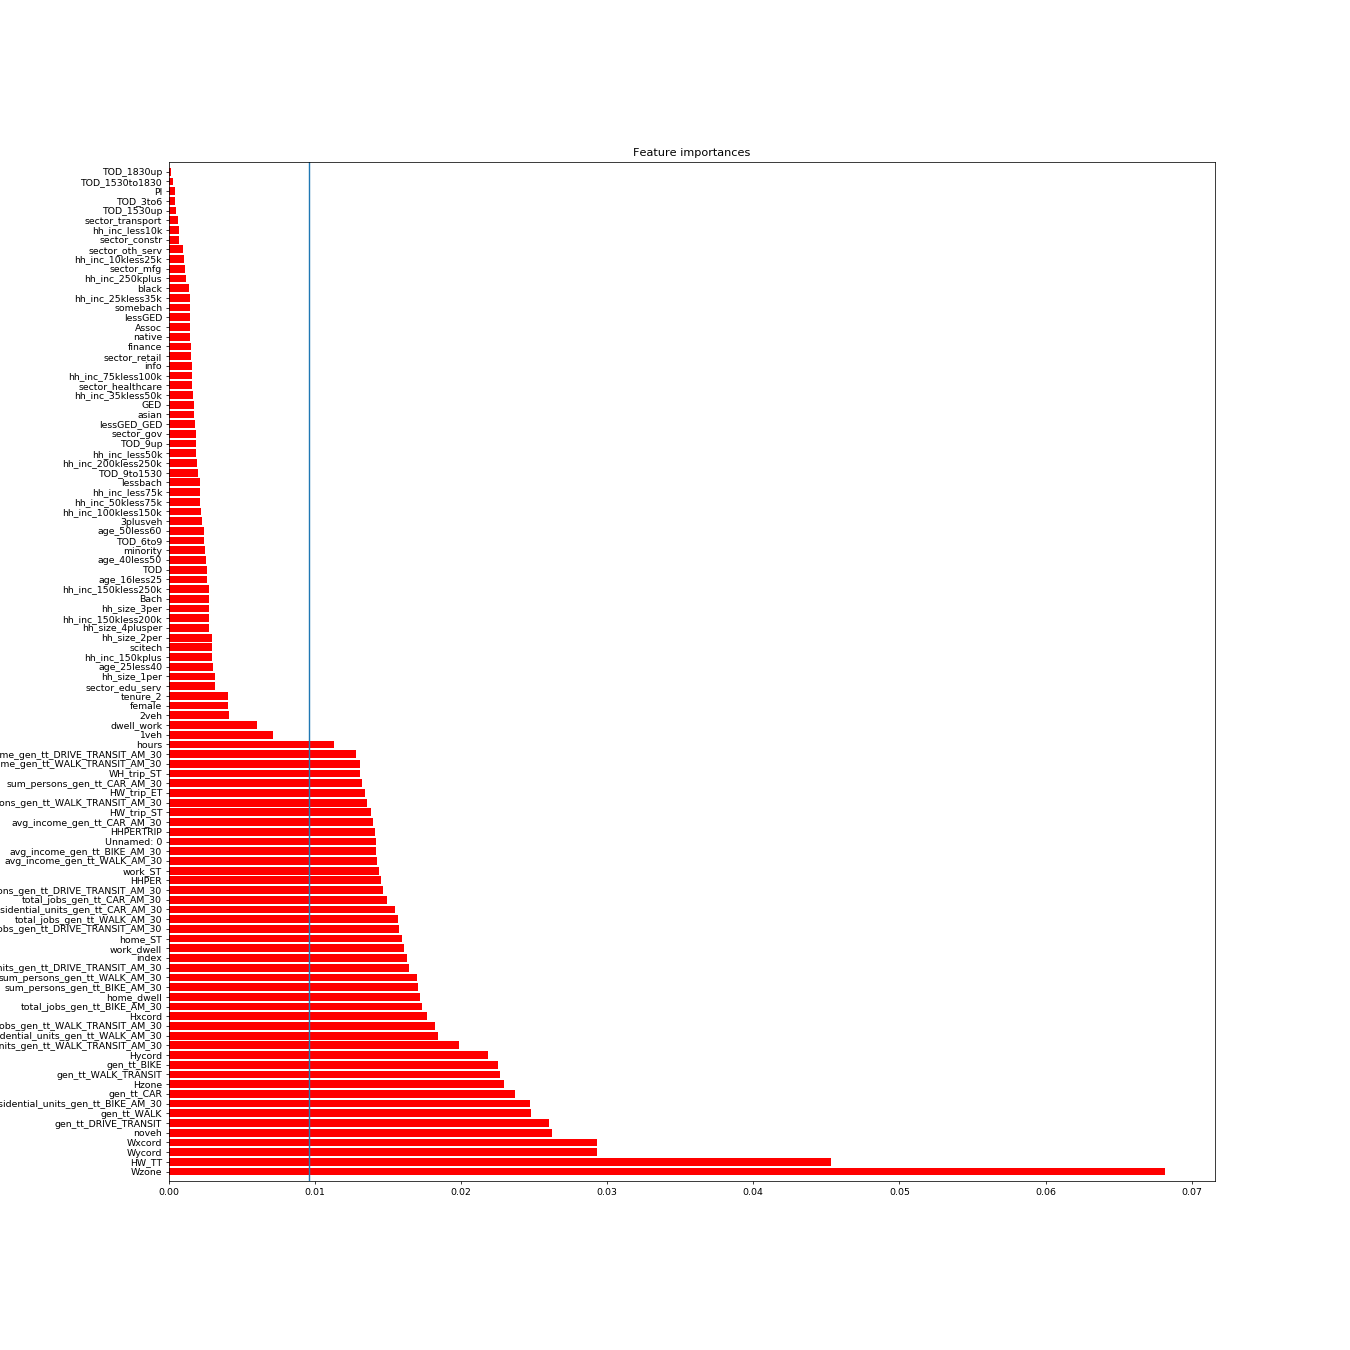

In [126]:
plt.figure(figsize = (20,20))
plt.title("Feature importances")
plt.barh(range(X0.shape[1]), importances[indices],
       color="r", align="center")
plt.axvline(importances.mean())
plt.yticks(range(X0.shape[1]), X0.columns[indices])
plt.ylim([-1, X0.shape[1]])
plt.show()

In [130]:
trips2.head()

,HHPER,index,Unnamed: 0,HHPERTRIP,origin,home_dwell,home_ST,HW_trip_ST,HW_trip_ET,HW_TT,Hzone,Wzone,Hxcord,Hycord,Wxcord,Wycord,HW_mode,work_dwell,work_ST,WH_trip_ST,WH_trip_ET,WH_TT,WH_mode,modeHW,TOD,dwell_work,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,hours,EDUCA,INDUS,HHVEH,OWN,...,gen_tt_CAR_AM,gen_tt_BIKE_AM,gen_tt_DRIVE_TRANSIT_AM,gen_tt_WALK_AM,gen_tt_WALK_TRANSIT_AM,gen_tt_CAR_PM,gen_tt_BIKE_PM,gen_tt_DRIVE_TRANSIT_PM,gen_tt_WALK_PM,gen_tt_WALK_TRANSIT_PM,gen_tt_CAR_OffPeak,gen_tt_BIKE_OffPeak,gen_tt_DRIVE_TRANSIT_OffPeak,gen_tt_WALK_OffPeak,gen_tt_WALK_TRANSIT_OffPeak,total_jobs_gen_tt_CAR_AM_30,total_jobs_gen_tt_WALK_TRANSIT_AM_30,total_jobs_gen_tt_DRIVE_TRANSIT_AM_30,total_jobs_gen_tt_BIKE_AM_30,total_jobs_gen_tt_WALK_AM_30,sum_residential_units_gen_tt_CAR_AM_30,sum_residential_units_gen_tt_WALK_TRANSIT_AM_30,sum_residential_units_gen_tt_DRIVE_TRANSIT_AM_30,sum_residential_units_gen_tt_BIKE_AM_30,sum_residential_units_gen_tt_WALK_AM_30,sum_persons_gen_tt_CAR_AM_30,sum_persons_gen_tt_WALK_TRANSIT_AM_30,sum_persons_gen_tt_DRIVE_TRANSIT_AM_30,sum_persons_gen_tt_BIKE_AM_30,sum_persons_gen_tt_WALK_AM_30,avg_income_gen_tt_CAR_AM_30,avg_income_gen_tt_WALK_TRANSIT_AM_30,avg_income_gen_tt_DRIVE_TRANSIT_AM_30,avg_income_gen_tt_BIKE_AM_30,avg_income_gen_tt_WALK_AM_30,gen_tt_CAR,gen_tt_BIKE,gen_tt_WALK,gen_tt_WALK_TRANSIT,gen_tt_DRIVE_TRANSIT
3992,30202193,9223,9547,3.020219e+09,home,14.583333,7.166667,21.750000,22.000000,0.250000,525.0,523.0,-121.896879,37.280818,-121.918797,37.264669,drive_alone,9.000000,22.000000,7.000000,7.166667,0.166667,drive_alone,0,4,4,3020219,3,1.0,21.0,0,1.0,NaN,NaN,NaN,30.0,2.0,44.0,1,1.0,...,3.509251,13.350405,5.868917,58.325964,8.841972,4.349597,13.422655,6.335453,52.656144,8.967193,3.276973,13.390643,5.991765,51.472567,8.924065,383050.0,186953.0,329860.0,75337.0,826.0,378239.0,233326.0,387325.0,106794.0,3272.0,998095.0,579609.0,1026804.0,253673.0,8064.0,282587.520824,280611.766021,284329.195532,279697.715188,336615.636364,3.276973,13.390643,51.472567,8.924065,5.991765
3203,25893411,7394,7663,2.589341e+09,home,13.933333,17.783333,7.716667,8.766667,1.050000,183.0,69.0,-122.496138,37.736289,-122.450262,37.776308,drive_alone,8.033333,8.766667,16.800000,17.783333,0.983333,drive_alone,0,1,3,2589341,1,2.0,37.0,0,4.0,NaN,NaN,NaN,40.0,6.0,52.0,1,1.0,...,9.487323,36.093055,15.866721,157.685268,23.904427,11.759213,36.288384,17.128008,142.356813,24.242964,14.166667,36.201839,16.198843,139.156989,24.126367,406461.0,104443.0,374588.0,31419.0,1541.0,436772.0,261837.0,420902.0,118796.0,10802.0,915147.0,599577.0,895780.0,273038.0,27471.0,227631.760137,229196.431064,227579.411547,235577.940921,220483.941379,9.487323,36.093055,157.685268,23.904427,15.866721
3155,25771411,7301,7560,2.577141e+09,home,13.433333,18.483333,7.916667,8.116667,0.200000,358.0,345.0,-122.133233,37.441851,-122.193415,37.425610,drive_alone,10.116667,8.116667,18.233333,18.483333,0.250000,drive_alone,0,1,4,2577141,1,1.0,59.0,0,1.0,NaN,NaN,NaN,60.0,6.0,52.0,3,1.0,...,8.799580,33.476644,14.716531,146.254552,22.171578,10.906779,33.657813,15.886386,132.037267,22.485574,8.217132,33.577542,15.024578,129.069401,22.377430,234609.0,116668.0,209636.0,86215.0,2254.0,167756.0,89839.0,173582.0,58338.0,3892.0,381778.0,207476.0,400774.0,133186.0,10738.0,374389.340936,382482.289292,377578.207537,379976.395742,449787.133518,8.799580,33.476644,146.254552,22.171578,14.716531
3957,30177401,9127,9449,3.017740e+09,home,11.233333,18.316667,5.550000,5.983333,0.433333,524.0,362.0,-121.900598,37.270067,-122.107763,37.430812,drive_alone,8.683333,5.983333,14.666667,18.316667,3.650000,drive_alone,0,0,3,3017740,1,1.0,65.0,0,1.0,NaN,NaN,NaN,40.0,5.0,31.0,1,1.0,...,20.100000,135.114149,59.396980,590.293922,89.486088,44.020548,135.845363,64.118601,532.911934,90.753401,33.164938,135.521383,60.640280,520.933413,90.316921,421610.0,172563.0,314525.0,69183.0,302.0,389931.0,204952.0,361718.0,101642.0,3928.0,1003951.0,487148.0,941734.0,234091.0,10742.0,277770.360660,279733.163

In [131]:
trips2.to_csv('/home/emma/activitysynth/activitysynth/data/HWtrips_042519.csv')


## Estimate the mode-to-work choice model

In [71]:
@orca.table(cache=True)
def tripsA():
    return trips2

In [91]:
m = SmallMultinomialLogitStep()
m.name = 'mode_to_work'
m.tables = ['tripsA']
m.choice_column = 'modeHW'
m.model_expression = OrderedDict([
    ('intercept', [0,1,3,5,6]), 
    
    ('gen_tt_CAR',[0]),
    ('gen_tt_WALK_TRANSIT',[2]),
    ('gen_tt_DRIVE_TRANSIT',[3]),
    ('gen_tt_BIKE',[5]),
    ('gen_tt_WALK',[6]),
    
    ('total_jobs_gen_tt_CAR_AM_30',[0]),
#     ('total_jobs_gen_tt_WALK_TRANSIT_AM_30',[2]),
#     ('total_jobs_gen_tt_DRIVE_TRANSIT_AM_30',[3]),
#     ('total_jobs_gen_tt_BIKE_AM_30',[5]),
    ('total_jobs_gen_tt_WALK_AM_30',[6]),
    
    ('sum_residential_units_gen_tt_CAR_AM_30',[0,1]),
#     ('sum_residential_units_gen_tt_WALK_TRANSIT_AM_30',[2]),
#     ('sum_residential_units_gen_tt_DRIVE_TRANSIT_AM_30',[3]),
#     ('sum_residential_units_gen_tt_BIKE_AM_30',[5]),
#     ('sum_residential_units_gen_tt_WALK_AM_30',[6]),
    
    ('sum_persons_gen_tt_CAR_AM_30',[0,1]),
#     ('sum_persons_gen_tt_WALK_TRANSIT_AM_30',[2]),
#     ('sum_persons_gen_tt_DRIVE_TRANSIT_AM_30',[3]),
#     ('sum_persons_gen_tt_BIKE_AM_30',[5]),
#     ('sum_persons_gen_tt_WALK_AM_30',[6]),
    
#     ('avg_income_gen_tt_CAR_AM_30',[0,1]),
#     ('avg_income_gen_tt_WALK_TRANSIT_AM_30',[2]),
#     ('avg_income_gen_tt_DRIVE_TRANSIT_AM_30',[3]),
#     ('avg_income_gen_tt_BIKE_AM_30',[5]),
#     ('avg_income_gen_tt_WALK_AM_30',[6]),
    
    ('TOD_3to6',[3]),
#     ('TOD_6to9',[1,2,3,5,6]),
#     ('TOD_9to1530',[1,2,3,5,6]),
#     ('TOD_1530to1830',[1,2]),
#     ('TOD_1830up',[1,2]),
#     ('TOD_1530up',[2,3]),
#     ('TOD_9up',[5,6]),

#     ('sector_constr',[1,2,3,5,6]),
    ('sector_mfg',[3]),
#     ('sector_retail',[3]),
#     ('sector_transport',[1,2,3,5,6]),
#     ('info',[1,2,3,5,6]),
    ('finance',[2,3]),
    ('scitech',[3]),
    ('sector_edu_serv',[5,6]),
    ('sector_healthcare',[3]),
    ('sector_gov',[2]),
    
    ('age_16less25',[1]),
    ('age_25less40',[2,5]),
#     ('age_40less50',[5]),
    ('age_50less60',[1]),
    
    ('female',[1,5]),
        
#     ('minority',[3]),
#     ('HISP',[1]),
#     ('black',[2]),
#     ('native',[3]),
#     ('asian',[3,5]),
# #     ('PI',[1,2,3,5,6]),
    
    ('hh_inc_less75k',[1,2]), 
#     ('hh_inc_250kplus',[1,2,3,5,6]),
    
#     ('hh_inc_less10k',[1,2,3,5,6]),
#     ('hh_inc_10kless25k',[1,2,3,5,6]),
#     ('hh_inc_25kless35k',[1,2,3,5,6]),
#     ('hh_inc_35kless50k',[1,2,3,5,6]),
    
# #     ('less50k',[1,2,4,5]),
#     ('hh_inc_50kless75k',[1,2,3,5,6]),
# #     ('hh_inc_75kless100k',[1,2,3,5,6]),
# #     ('100kless150k')

#     ('hh_inc_150kless200k',[1,2,3,5,6]),
#     ('hh_inc_200kless250k',[1,2,3,5,6]),
#     ('hh_inc_250kplus',[1,2,3,5,6]),
 
#     ('lessGED',[3]),
#     ('GED',[3]),
    ('lessGED_GED',[2]),
    ('somebach',[2]),
    ('Assoc',[2,6]),
    ('lessbach',[5]),
#     ('Bach',[5]),
    
#     ('hours',[2]),
    
    ('noveh',[1,2,5,6]),

    ('hh_size_3per',[2]),
    ('hh_size_4plusper',[2]),
    
    ('tenure_2',[2,6]),
    
])

In [92]:
m.fit()

Log-likelihood at zero: -6,572.1737
Initial Log-likelihood: -6,572.1737
Estimation Time for Point Estimation: 0.80 seconds.
Final log-likelihood: -2,594.6724
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:                3,668
Model:             Multinomial Logit Model   Df Residuals:                    3,622
Method:                                MLE   Df Model:                           46
Date:                     Tue, 23 Apr 2019   Pseudo R-squ.:                   0.605
Time:                             16:02:21   Pseudo R-bar-squ.:               0.598
AIC:                             5,281.345   Log-Likelihood:             -2,594.672
BIC:                             5,566.885   LL-Null:                    -6,572.174
                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [93]:
m.name = 'mode_to_work'

In [94]:
mm.initialize()

Registering model step 'auto_ownership'
Registering model step 'dwell_work'
Registering model step 'TOD_choice'
Registering model step 'work_TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'mode_to_work'
Registering model step 'WLCM'


In [95]:
m.tags = ['mode_to_work','emma']
mm.register(m)

Saving 'mode_to_work.yaml': /home/emma/activitysynth/activitysynth/configs
Model saved to configs/mode_to_work-model-object.pkl
Registering model step 'mode_to_work'


## Validate model on reserved data

In [96]:
trips_validate['modeHW_actual'] = trips_validate['modeHW']

In [97]:
@orca.table(cache=True)
def tripsA():
    return trips_validate

In [98]:
m = mm.get_step('mode_to_work')

In [99]:
m.run()

In [100]:
trips_validate.head()

,HHPER,index,Unnamed: 0,HHPERTRIP,origin,home_dwell,home_ST,HW_trip_ST,HW_trip_ET,HW_TT,Hzone,Wzone,Hxcord,Hycord,Wxcord,Wycord,HW_mode,work_dwell,work_ST,WH_trip_ST,WH_trip_ET,WH_TT,WH_mode,modeHW,TOD,dwell_work,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,hours,EDUCA,INDUS,HHVEH,OWN,...,gen_tt_BIKE_AM,gen_tt_DRIVE_TRANSIT_AM,gen_tt_WALK_AM,gen_tt_WALK_TRANSIT_AM,gen_tt_CAR_PM,gen_tt_BIKE_PM,gen_tt_DRIVE_TRANSIT_PM,gen_tt_WALK_PM,gen_tt_WALK_TRANSIT_PM,gen_tt_CAR_OffPeak,gen_tt_BIKE_OffPeak,gen_tt_DRIVE_TRANSIT_OffPeak,gen_tt_WALK_OffPeak,gen_tt_WALK_TRANSIT_OffPeak,total_jobs_gen_tt_CAR_AM_30,total_jobs_gen_tt_WALK_TRANSIT_AM_30,total_jobs_gen_tt_DRIVE_TRANSIT_AM_30,total_jobs_gen_tt_BIKE_AM_30,total_jobs_gen_tt_WALK_AM_30,sum_residential_units_gen_tt_CAR_AM_30,sum_residential_units_gen_tt_WALK_TRANSIT_AM_30,sum_residential_units_gen_tt_DRIVE_TRANSIT_AM_30,sum_residential_units_gen_tt_BIKE_AM_30,sum_residential_units_gen_tt_WALK_AM_30,sum_persons_gen_tt_CAR_AM_30,sum_persons_gen_tt_WALK_TRANSIT_AM_30,sum_persons_gen_tt_DRIVE_TRANSIT_AM_30,sum_persons_gen_tt_BIKE_AM_30,sum_persons_gen_tt_WALK_AM_30,avg_income_gen_tt_CAR_AM_30,avg_income_gen_tt_WALK_TRANSIT_AM_30,avg_income_gen_tt_DRIVE_TRANSIT_AM_30,avg_income_gen_tt_BIKE_AM_30,avg_income_gen_tt_WALK_AM_30,gen_tt_CAR,gen_tt_BIKE,gen_tt_WALK,gen_tt_WALK_TRANSIT,gen_tt_DRIVE_TRANSIT,modeHW_actual
1,10417661,4,4,1.041766e+09,home,13.250000,18.750000,8.000000,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone,8.500000,9.000000,17.500000,18.750000,1.250000,drive_alone,0,2,3,1041766,1,2.0,43.0,0,4.0,NaN,NaN,NaN,40.0,6.0,62.0,2,1.0,...,100.899543,44.356037,440.815322,66.825758,32.873338,101.445594,47.882014,397.964026,67.772152,24.766667,101.203654,45.284499,389.018795,67.446201,207140.0,81488.0,147700.0,38336.0,1340.0,192195.0,76778.0,168205.0,38674.0,4929.0,487210.0,193030.0,430088.0,98600.0,11943.0,295876.140448,302779.281580,294804.449967,301893.854412,325692.574780,26.522181,100.899543,440.815322,66.825758,44.356037,0
3,10436132,8,8,1.043613e+09,home,11.866667,19.400000,7.266667,7.866667,0.600000,1004.0,1127.0,-122.252523,37.851942,-122.069993,37.969472,drive_alone,11.133333,7.866667,19.000000,19.400000,0.400000,drive_alone,2,1,5,1043613,2,1.0,54.0,0,1.0,NaN,NaN,NaN,12.0,6.0,61.0,2,1.0,...,109.352563,48.072035,477.745330,72.424193,35.627355,109.944360,51.893406,431.304097,73.449872,26.841534,109.682152,49.078280,421.609465,73.096614,268208.0,186904.0,247548.0,148697.0,3203.0,303669.0,188539.0,284921.0,124459.0,4850.0,627408.0,361920.0,586880.0,222946.0,9907.0,274142.466734,279242.555843,274601.588402,280311.173524,327825.009765,28.744119,109.352563,477.745330,72.424193,48.072035,0
5,10456721,12,12,1.045672e+09,home,13.050000,18.166667,7.216667,8.050000,0.833333,1100.0,971.0,-121.943350,37.953765,-122.265385,37.806308,DrTranW,9.200000,8.050000,17.250000,18.166667,0.916667,WTranDr,0,1,4,1045672,1,1.0,59.0,0,1.0,NaN,NaN,NaN,40.0,6.0,62.0,3,1.0,...,165.706031,72.845353,723.945377,88.916667,53.987464,166.602803,78.636020,653.571240,111.301340,40.673981,166.205469,74.370155,638.880601,110.766035,129118.0,26097.0,122077.0,6916.0,1194.0,175262.0,52353.0,132098.0,24134.0,3128.0,435727.0,127845.0,317525.0,60043.0,7624.0,243347.559641,246757.310693,238305.223578,262967.889832,140834.153672,43.557040,165.706031,723.945377,88.916667,72.845353,3
7,10513882,20,20,1.051388e+09,home,16.500000,15.516667,8.016667,8.583333,0.566667,89.0,4.0,-122.445773,37.767279,-122.401963,37.789680,drive_alone,6.083333,8.583333,14.666667,15.516667,0.850000,drive_alone,0,1,2,1051388,2,1.0,48.0,0,1.0,NaN,NaN,NaN,40.0,3.0,44.0,2,1.0,...,24.755274,27.750000,108.152164,33.712500,8.065334,24.889245,11.747648,97.638780,16.627609,6.800000,24.829886,11.110359,95.444106,36.161111,445339.0,393850.0,447404.0,360768.0,6787.0,443492.0,383891.0,431093.0,318970.0,19427.0,921909.0,768427.0,888818.0,604627.0,36589.0,280577.253225,283729.500922,281548.321572,292073.486538,306411.558606,14.066

In [149]:
validate = pd.crosstab(index=trips_validate["modeHW_actual"], 
                           columns=trips_validate["modeHW"],
                      margins = True, margins_name = 'Total'
                      )

# validate.index= ["drive_alone","shared","WTranW","DrTranW","bike","walk","Total"]
# 
validate

modeHW,0,1,2,3,5,6,Total
modeHW_actual,,,,,,,
0,774,35,49,47,22,10,937
1,45,3,3,7,4,0,62
2,47,4,31,6,2,2,92
3,58,4,3,5,2,0,72
5,19,0,7,2,4,3,35
6,11,0,3,2,2,6,24
Total,954,46,96,69,36,21,1222


In [144]:
N = len(trips_validate.modeHW)
crosstab = pd.crosstab(index=trips_validate["modeHW_actual"], 
                           columns=trips_validate["modeHW"]
#                       margins = True, margins_name = 'Total'
                      )
rowsum = crosstab.sum(axis = 1)

mutual_choices = set(crosstab.index.values) & set(crosstab.columns.values)
# all_choices = set(crosstab.index.values) | set(crosstab.columns.values)

tp_rate_all = sum([crosstab.at[c,c] for c in mutual_choices]) / N

tp_rate_all
# tp_rate_table = pd.DataFrame(columns = mutual_choices, index = ['True Positive rate'])
# # for c in all_choices:
# #     if c not in mutual_choices:
# #         tp_rate_table.iloc[0,c] = 0
# #     else:
# tp_rate_table.iloc[0,c] = crosstab.at[c,c] / rowsum.at[c]
# tp_rate_table['all'] = tp_rate_all

0.6734860883797054

In [111]:
validate = pd.crosstab(index=trips_validate["modeHW_actual"], 
                           columns=trips_validate["modeHW"], normalize='index')

validate.columns= ["drive_alone","shared","WTranW","DrTranW","bike","walk"]

validate

,drive_alone,shared,WTranW,DrTranW,bike,walk
modeHW_actual,,,,,,
0,0.826041,0.037353,0.052295,0.050160,0.023479,0.010672
1,0.725806,0.048387,0.048387,0.112903,0.064516,0.000000
2,0.510870,0.043478,0.336957,0.065217,0.021739,0.021739
3,0.805556,0.055556,0.041667,0.069444,0.027778,0.000000
5,0.542857,0.000000,0.200000,0.057143,0.114286,0.085714
6,0.458333,0.000000,0.125000,0.083333,0.083333,0.250000


In [ ]:
validate = pd.crosstab(index=trips_validate["modeHW_actual"], 
                           columns=trips_validate["modeHW"],
                      margins = True, margins_name = 'Total')

# validate.index= ["drive_alone","shared","WTranW","DrTranW","bike","walk"]

validate

In [163]:
validate = pd.crosstab(index=trips_validate["modeHW_actual"], 
                           columns=trips_validate["modeHW"], normalize='index')

# validate.index= ["drive_alone","shared","WTranW","DrTranW","bike","walk"]

validate

modeHW,0,1,2,3,5,6
modeHW_actual,,,,,,
0,0.800429,0.047210,0.063305,0.050429,0.024678,0.013948
1,0.800000,0.033333,0.066667,0.083333,0.016667,0.000000
2,0.609195,0.034483,0.195402,0.045977,0.068966,0.045977
3,0.727273,0.077922,0.025974,0.090909,0.051948,0.025974
5,0.750000,0.050000,0.025000,0.000000,0.150000,0.025000
6,0.520000,0.080000,0.320000,0.040000,0.040000,0.000000


## Estimate the model for Home-to-Work Trip End Times

In [32]:
###model with p-values less than .01 (except hours4)

m = SmallMultinomialLogitStep()
m.name = 'work_TOD_choice'
m.tables = ['tripsA']
m.choice_column = 'TOD'
m.model_expression = OrderedDict([
    ('intercept', [0,1,3,4]), 
    
    ('sector_constr',[2,3]),
    ('sector_mfg',[0,2,3]),
    ('sector_retail',[2]),
    ('sector_transport',[0]),
    ('info',[0,2,3]),
    ('finance',[0,2,3]),
    ('scitech',[0,3]),
    ('sector_edu_serv',[0,2,3]),
    ('sector_healthcare',[0,2,3,4]),
    ('sector_oth_serv',[0,3]),
    ('sector_gov',[2,3]),
    
    ('age_16less25',[2,3,4]),
    ('age_25less40',[0]),
    
    ('female',[0,3,4]),
    
    ('minority',[0,4]),
    ('asian',[2]),
    
    ('hh_inc_less75k',[4]), 
#     ('75kless150k')
    ('hh_inc_150kless250k',[0]),
    ('hh_inc_250kplus',[0,2]),

    ('lessGED',[0,2,3]),
    ('GED',[0,2,3]),
    ('somebach',[0,2]),
    ('Assoc',[0,2]),
    ('no_higher_ed',[4]),
    ('Bach',[0,2,4]),
#     ('Grad')
       
    ('hours',[0,2,3,4]),

    ('noveh',[2]),

    ('hh_size_1per',[2]),
    
    ('tenure_2',[2]),
    
])

In [33]:
m.fit()

Log-likelihood at zero: -28,878.1445
Initial Log-likelihood: -28,878.1445
Estimation Time for Point Estimation: 15.62 seconds.
Final log-likelihood: -16,303.6766
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:               17,943
Model:             Multinomial Logit Model   Df Residuals:                   17,878
Method:                                MLE   Df Model:                           65
Date:                     Fri, 29 Mar 2019   Pseudo R-squ.:                   0.435
Time:                             13:51:59   Pseudo R-bar-squ.:               0.433
AIC:                            32,737.353   Log-Likelihood:            -16,303.677
BIC:                            33,244.025   LL-Null:                   -28,878.144
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [34]:
m.name = 'work_TOD_choice'

In [35]:
m.tags = ['work_TOD_choice','emma']
mm.register(m)

Saving 'work_TOD_choice.yaml': /home/emma/activitysynth/activitysynth/configs
Model saved to configs/work_TOD_choice-model-object.pkl
Registering model step 'work_TOD_choice'
